### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [1]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip install -U albumentations>=0.3.0 --user 
!pip install -U --pre segmentation-models --user

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
  File "C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
  File "C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 98, in read
    data: bytes = self.__fp.read(amt)
  File "C:\Users\User\AppData\Local\Programs\Python\Python38\lib\http\client.py", line 454, in read
    n = self.readinto(b)
  File "C:\Users\User\AppData\Local\Programs\Python\Python38\lib\http\client.py", line 498, in readinto

# Loading dataset

In [2]:
import os
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Num GPUs Available:  1


In [ ]:
DATA_DIR = 'C:\ellie\study\models\Sacrum'

In [4]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

# Dataloader and utility functions 

In [35]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap='gray')
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

# classes for data loading and preprocessing
class Dataset:
    
    CLASSES = ['background', 'bone']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id.replace('.jpg', '.npy')) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes] # type: ignore
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_GRAYSCALE)
        image = np.expand_dims(image, axis=-1)  # 添加通道維度
        mask = np.load(self.masks_fps[i])
        
        # Process the mask: set all non-background (non-zero) labels to 1
        mask = np.where(mask != 0, 1, 0).astype('float')  # Background = 0, Bone = 1
        
         # Extract relevant classes (background and bone)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence): # type: ignore
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = [self.dataset[j] for j in range(start, stop)]
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)


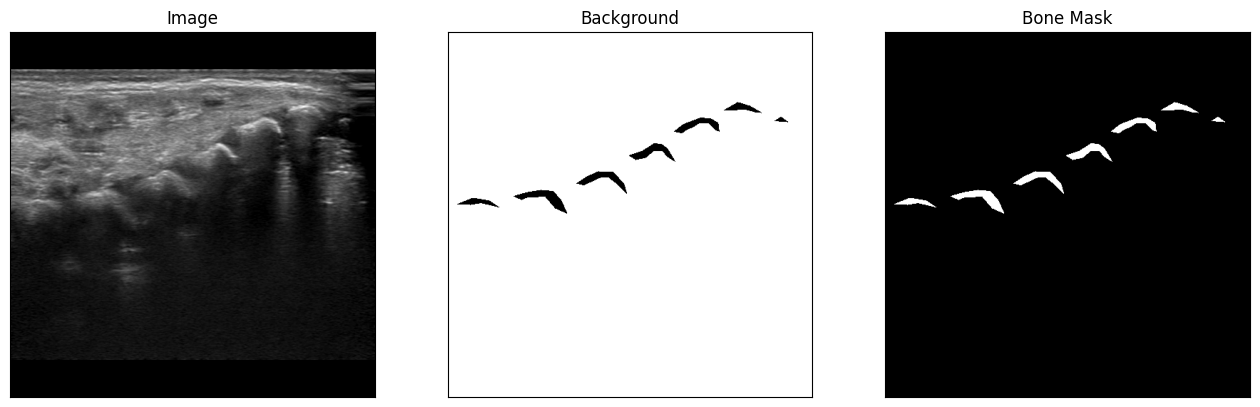

In [14]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['background', 'bone'])

image, mask = dataset[0] # get some sample

# 可視化影像和標註
visualize(
    image=image, 
    background=mask[..., 0].squeeze(),
    bone_mask=mask[..., 1].squeeze()
)

### Augmentations

In [15]:
import albumentations as A # type: ignore

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


In [16]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.3),
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=0.1, shift_limit=0.1, p=0.5, border_mode=0),
        A.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.GaussNoise(p=0.5),  
        
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightnessContrast(brightness_limit=2, contrast_limit=0, p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomBrightnessContrast(brightness_limit=0, contrast_limit=2, p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
        A.PadIfNeeded(512, 512)
    ]
    return A.Compose(test_transform) # type: ignore

def get_preprocessing(preprocessing_fn):
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform) # type: ignore

def custom_preprocessing(image, **kwargs):
    """Apply preprocessing for grayscale images"""
    if image.shape[-1] == 1:
        image = np.repeat(image, 3, axis=-1)  # 將灰階影像複製成3個通道
    image = image.astype(np.float32) / 255.0
    return image

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\albucore\utils.py:113: UserWarning: HueSaturationValue: hue_shift and sat_shift are not applicable to grayscale image. Set them to 0 or use RGB image
  result = func(img, *args, **kwargs)


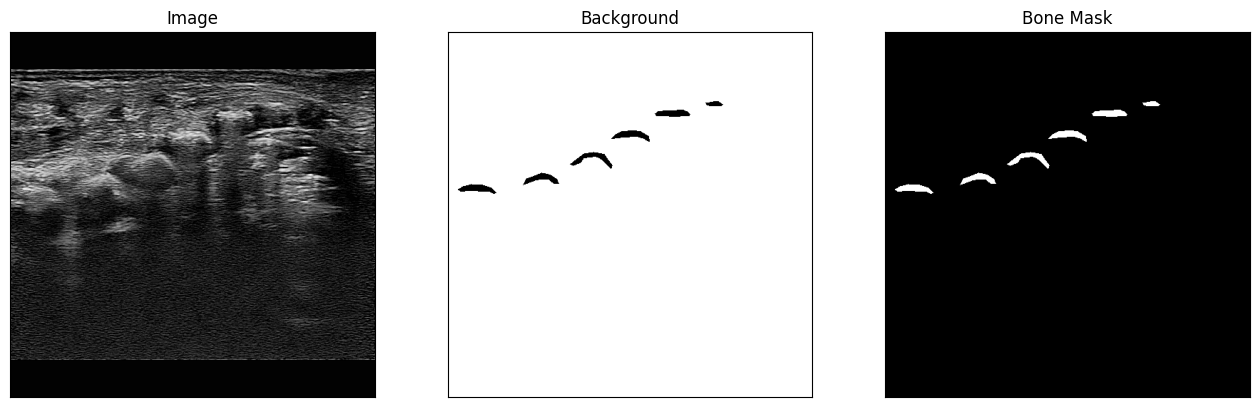

In [17]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['background', 'bone'], augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    background=mask[..., 0].squeeze(),
    bone_mask=mask[..., 1].squeeze()
)

# Segmentation model training

In [ ]:
import segmentation_models as sm
from keras.models import Model
from keras.layers import Input, Conv2D
from keras.applications import EfficientNetB7

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


In [ ]:
BACKBONE = 'efficientnetb7'
BATCH_SIZE = 4
CLASSES = ['background', 'bone']
LR = 0.0001
EPOCHS = 100

# Define preprocessing function
preprocess_input = custom_preprocessing

In [20]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES))  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet')

In [25]:
import keras.backend as K # type: ignore

# define optomizer
optim = keras.optimizers.Adam(LR) # type: ignore

class DiceLossWithClip(sm.losses.DiceLoss):
    def __init__(self, class_weights=None, **kwargs):
        super().__init__(class_weights=class_weights, **kwargs)

    def __call__(self, y_true, y_pred):
        dice_loss = super().__call__(y_true, y_pred)
        return K.clip(dice_loss, 0, 1)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss 
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 1])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:

# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
print("Shape of images in train_dataloader:", train_dataloader[0][0].shape)
print("Shape of masks in train_dataloader:", train_dataloader[0][1].shape)

assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 512, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./sacrum_unet_effB7_1129.h5', save_best_only=True, mode='min'), # type: ignore
    keras.callbacks.ReduceLROnPlateau(), # type: ignore
]

Shape of images in train_dataloader: (8, 512, 512, 3)
Shape of masks in train_dataloader: (8, 512, 512, 2)


In [27]:
# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/100
8/8 [==============================] - 20s 645ms/step - loss: 0.6625 - iou_score: 0.3496 - f1-score: 0.4238 - val_loss: 0.6724 - val_iou_score: 0.3424 - val_f1-score: 0.4249 - lr: 1.0000e-04
Epoch 2/100
8/8 [==============================] - 3s 318ms/step - loss: 0.6441 - iou_score: 0.3454 - f1-score: 0.4222 - val_loss: 0.7293 - val_iou_score: 0.1001 - val_f1-score: 0.1710 - lr: 1.0000e-04
Epoch 3/100
8/8 [==============================] - 3s 320ms/step - loss: 0.6310 - iou_score: 0.3636 - f1-score: 0.4378 - val_loss: 0.8130 - val_iou_score: 0.0205 - val_f1-score: 0.0401 - lr: 1.0000e-04
Epoch 4/100
8/8 [==============================] - 3s 323ms/step - loss: 0.6143 - iou_score: 0.3956 - f1-score: 0.4641 - val_loss: 0.8671 - val_iou_score: 0.0144 - val_f1-score: 0.0284 - lr: 1.0000e-04
Epoch 5/100
8/8 [==============================] - 3s 312ms/step - loss: 0.6036 - iou_score: 0.4338 - f1-score: 0.4963 - val_loss: 0.8537 - val_iou_score: 0.0166 - val_f1-score: 0.0327 - lr: 

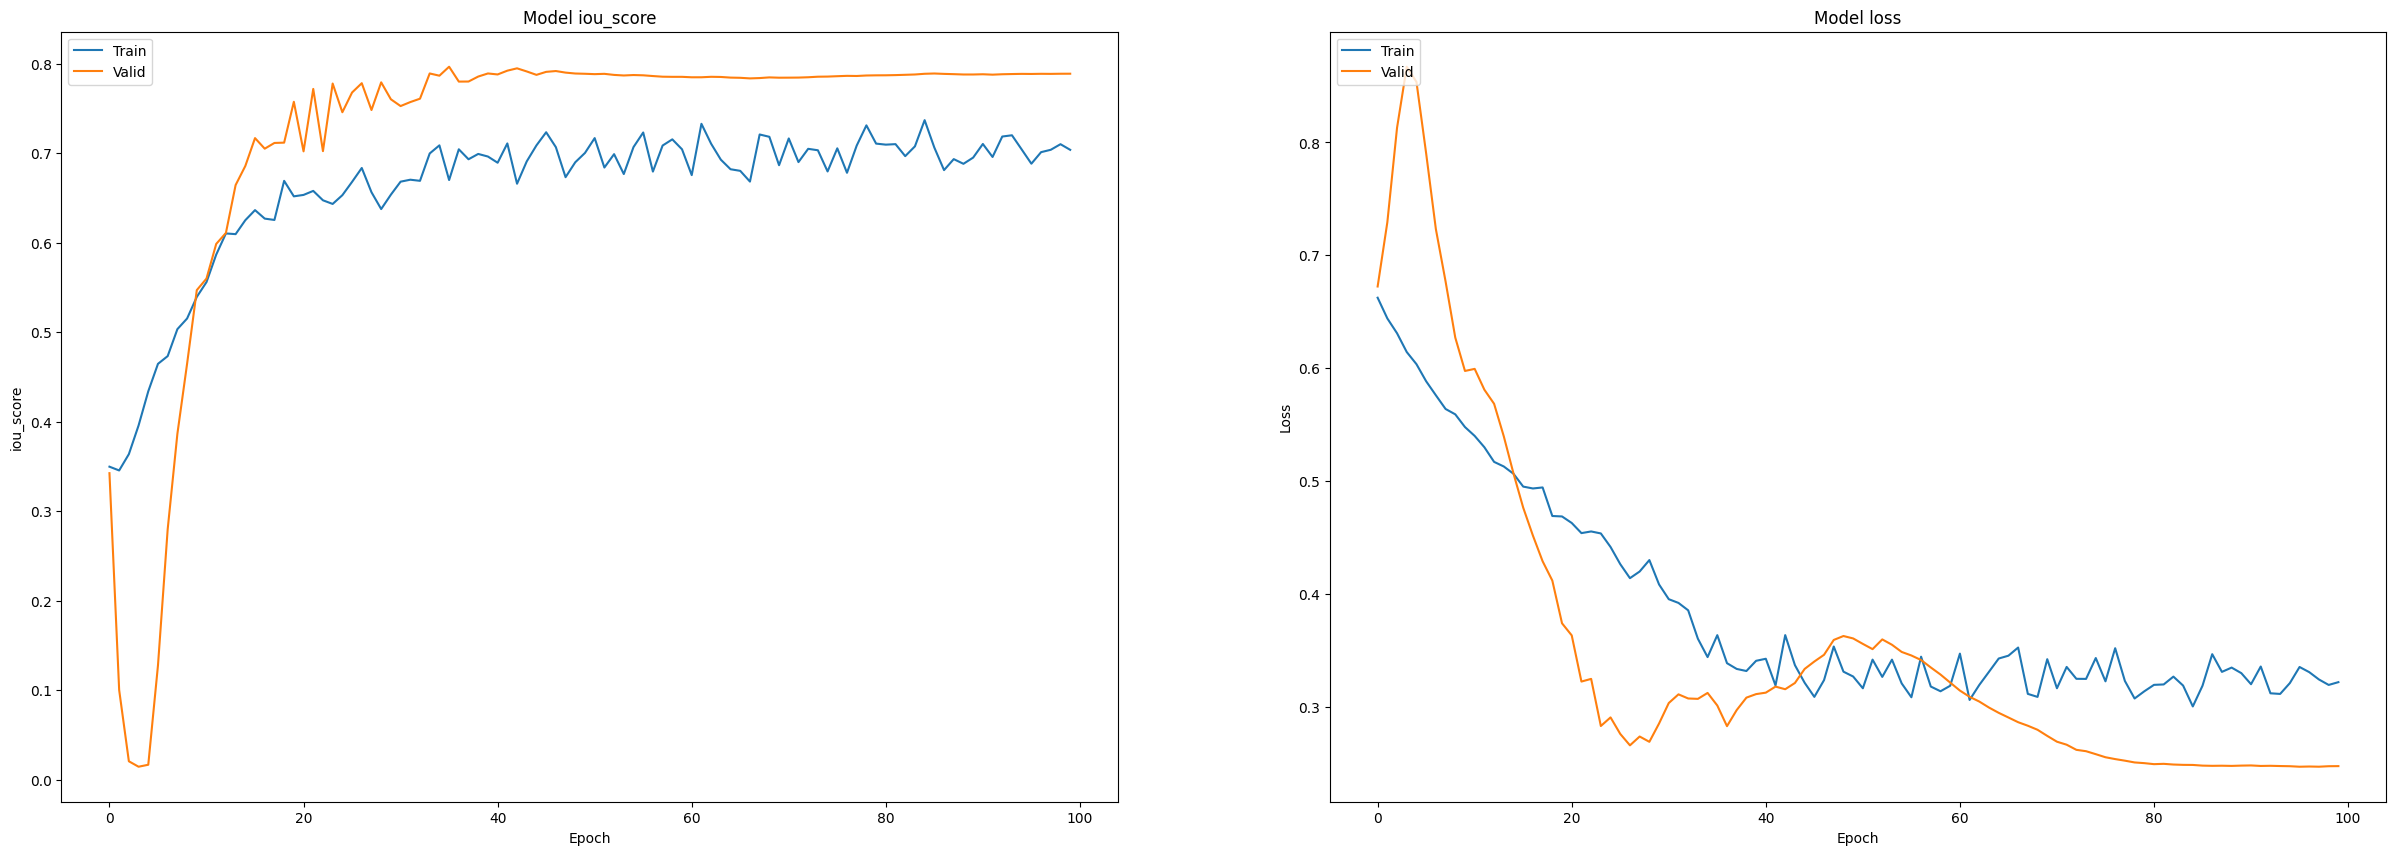

In [29]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 10))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Model Evaluation

In [30]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# load best weights
model.load_weights('sacrum_unet_effB7_1129.h5') 

In [32]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

C:\Users\User\AppData\Local\Temp\ipykernel_13072\3518042878.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_dataloader)


Loss: 0.21943
mean iou_score: 0.82642
mean f1-score: 0.89574


# Visualization of results on test dataset

In [38]:
# Define a function to convert mask to color
def mask_to_color(mask, num_classes=2):
    """
    Convert a mask with shape (H, W, num_classes) to a color image.
    """
    colors = np.array([
        [0, 0, 0],  # background
        [255, 255, 255],  # bone
    ])
    mask = np.argmax(mask, axis=-1)
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for c in range(num_classes):
        color_mask[mask == c] = colors[c]
    return color_mask

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if name == 'image':
            plt.imshow(image, cmap='gray')
        else:
            plt.imshow(mask_to_color(image))
    plt.show()

1/1 [==============================] - 0s 30ms/step


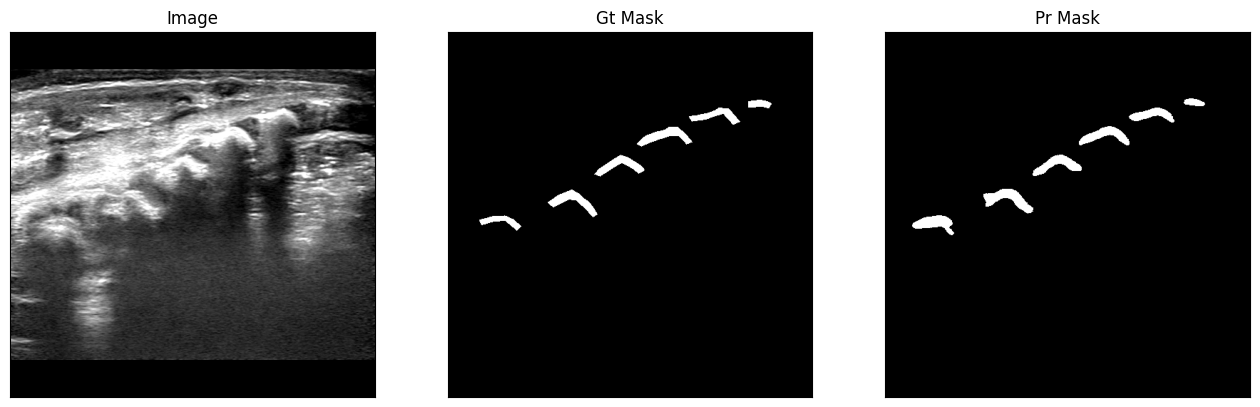

1/1 [==============================] - 0s 29ms/step


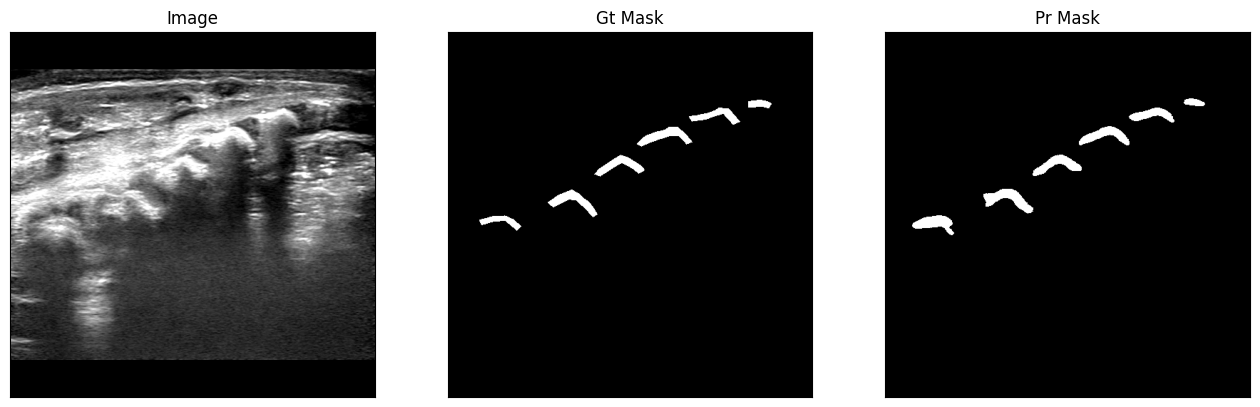

1/1 [==============================] - 0s 30ms/step


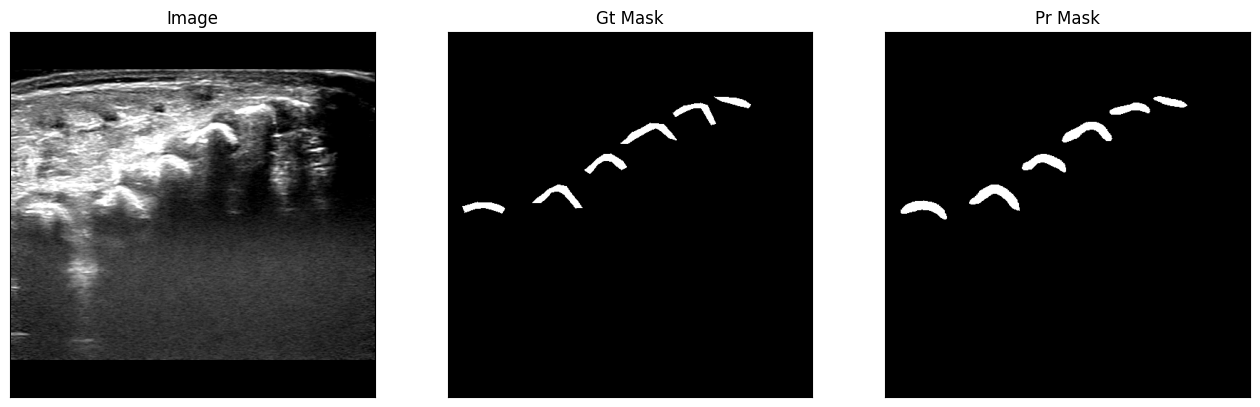

1/1 [==============================] - 0s 34ms/step


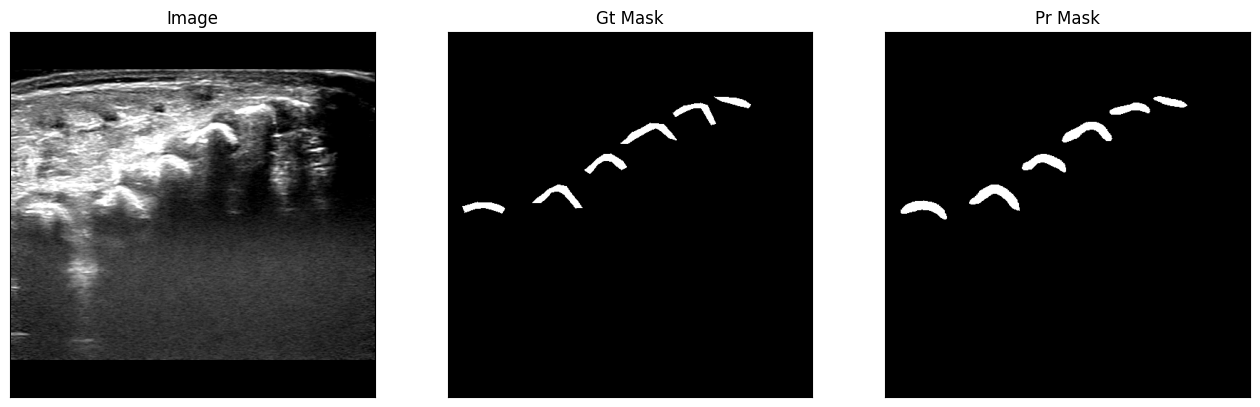

1/1 [==============================] - 0s 33ms/step


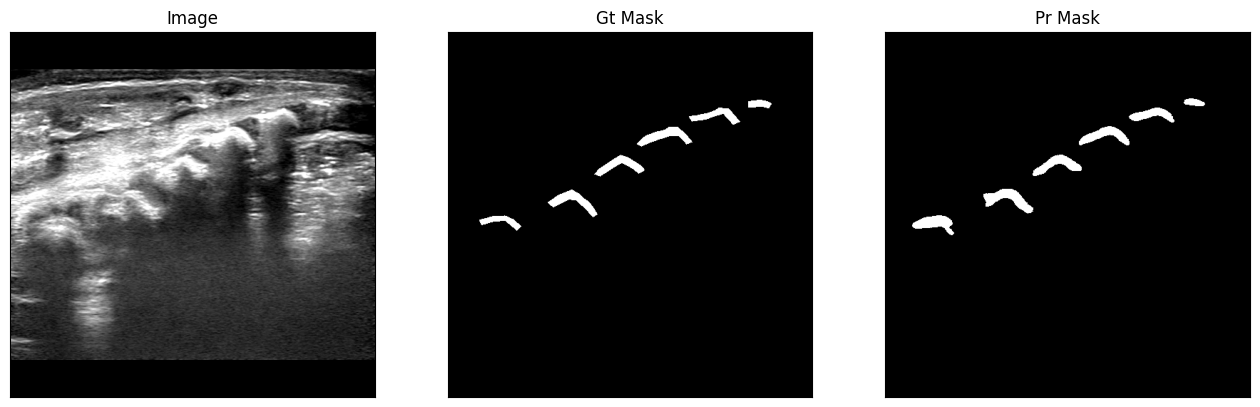

In [48]:
n = 2
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )

In [24]:
import keras.backend as K

# 每次訓練後清理 Keras 會話
def clear_keras_session():
    K.clear_session()
    
clear_keras_session()